# Extract CSV from image

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
root = '/home/user/Dev/Git/roofcounting/'
# image_name = "pasirsari_1_labeled" 
image_name = "IMG_9_pts"
# image_ext = ".png"
image_ext = ".jpg"
image_file = os.path.join("data/images/", (image_name + image_ext))
image_path = os.path.join(root, image_file)
image = cv2.imread(image_path)
# print(image_path)

In [3]:
# adaptive threshold as preprocessing -> looks for areas that are relatively brighter than the neighbouring pixels
blur_hor = cv2.filter2D(image[:, :, 0], cv2.CV_32F, kernel=np.ones((11,1,1), np.float32)/11.0, borderType=cv2.BORDER_CONSTANT)
blur_vert = cv2.filter2D(image[:, :, 0], cv2.CV_32F, kernel=np.ones((1,11,1), np.float32)/11.0, borderType=cv2.BORDER_CONSTANT)
mask = ((image[:,:,0]>blur_hor*1.2) | (image[:,:,0]>blur_vert*1.2)).astype(np.uint8)*255

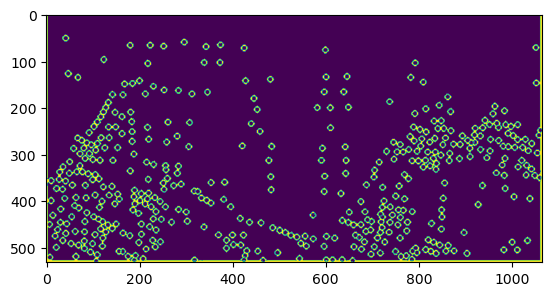

In [4]:
plt.imshow(mask)

In [5]:
circles = cv2.HoughCircles(mask,
                           cv2.HOUGH_GRADIENT,
                           minDist=2,
                           dp=1,
                           param1=150,
                           param2=12,
                           minRadius=4,
                           maxRadius=10)
output = image.copy()
for (x, y, r) in circles[0, :, :]:
    cv2.circle(output, (int(x), int(y)), int(r), (0, 255, 0), 4)

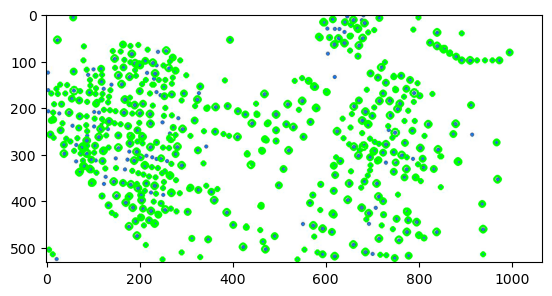

In [6]:
plt.imshow(output)

In [7]:
xy_array = []

for i in range(len(circles[0])):
    xy = circles[0][i][0], circles[0][i][1]
    xy_array.append(xy)

df = pd.DataFrame(xy_array, columns=["x", "y"])
df.to_csv(image_name + ".csv", index=False)
print(df.shape)

(523, 2)


# now create dataset

In [8]:
import h5py
import scipy.io as io
# import PIL.Image as Image
from PIL import Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
from image import *
# from model import CSRNet
import torch
%matplotlib inline

from model import CSRNet

/home/user/anaconda3/envs/roofcounting/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [9]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

#     pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [10]:
ps_img = cv2.imread(image_path)
# print(image_path)
gray = cv2.cvtColor(ps_img, cv2.COLOR_BGR2GRAY)
xy = pd.read_csv(image_name + ".csv")
xy = xy.to_numpy()

In [11]:
k = np.zeros((ps_img.shape[0], ps_img.shape[1]))
gt = xy
for i in range(0, len(gt)):
    if int(gt[i][1])<ps_img.shape[0] and int(gt[i][0])<ps_img.shape[1]:
        k[int(gt[i][1]), int(gt[i][0])] = 1
k1 = gaussian_filter_density(k)  

(532, 1066)
generate density...
done.


519.0468


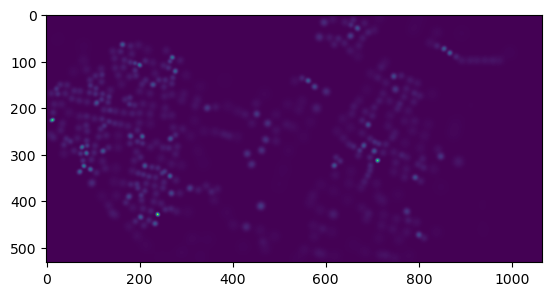

In [12]:
plt.imshow(k1)
print(np.sum(k1))

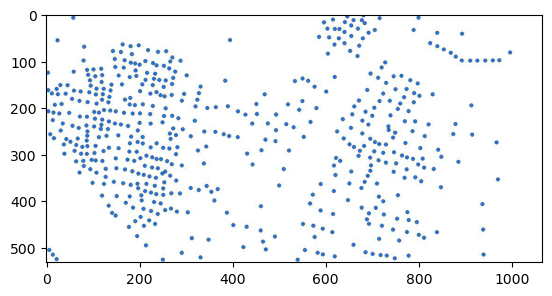

In [13]:
plt.imshow(ps_img)